In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

# 1. Generate Synthetic Data
np.random.seed(42)
means = np.array([[0, 0], [5, 5], [0, 5]])
covariances = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.3], [-0.3, 1]], [[1, 0], [0, 1]]])
weights = np.array([0.4, 0.35, 0.25])
n_samples = 500
n_samples_component = np.random.multinomial(n_samples, weights)
samples = []
for i in range(3):
    samples_component = np.random.multivariate_normal(
        means[i], covariances[i], n_samples_component[i]
    )
    samples.append(samples_component)
X = np.vstack(samples)
np.random.shuffle(X)


In [5]:
X.shape

(500, 2)

In [6]:
# 2. Initialize Parameters
k = 3
n, d = X.shape
np.random.seed(0)
mu = X[np.random.choice(n, k, False), :]
sigma = np.array([np.eye(d) for _ in range(k)])
pi = np.ones(k) / k
gamma = np.zeros((n, k))

# 3. EM Algorithm
tol = 1e-6
max_iter = 100
log_likelihoods = []

for iteration in range(max_iter):
    # E-step
    for i in range(k):
        rv = multivariate_normal(mean=mu[i], cov=sigma[i])
        gamma[:, i] = pi[i] * rv.pdf(X)
    likelihood = np.sum(gamma, axis=1).reshape(-1, 1)
    gamma /= likelihood

    # M-step
    N_k = np.sum(gamma, axis=0)
    for i in range(k):
        mu[i] = np.sum(gamma[:, i].reshape(-1, 1) * X, axis=0) / N_k[i]
        X_centered = X - mu[i]
        sigma[i] = (gamma[:, i].reshape(-1, 1) * X_centered).T @ X_centered / N_k[i]
    pi = N_k / n

    # Log-likelihood
    log_likelihood = np.sum(np.log(likelihood))
    log_likelihoods.append(log_likelihood)

    # Convergence Check
    if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
        break

    print(f"Iteration {iteration + 1}, Log-Likelihood: {log_likelihood:.4f}")

# 4. Visualize Results
cluster_assignments = np.argmax(gamma, axis=1)


Iteration 1, Log-Likelihood: -2370.7308
Iteration 2, Log-Likelihood: -1901.2236
Iteration 3, Log-Likelihood: -1893.8465
Iteration 4, Log-Likelihood: -1893.5852
Iteration 5, Log-Likelihood: -1893.5774
Iteration 6, Log-Likelihood: -1893.5769
Iteration 7, Log-Likelihood: -1893.5768
Iteration 8, Log-Likelihood: -1893.5768
Iteration 9, Log-Likelihood: -1893.5768


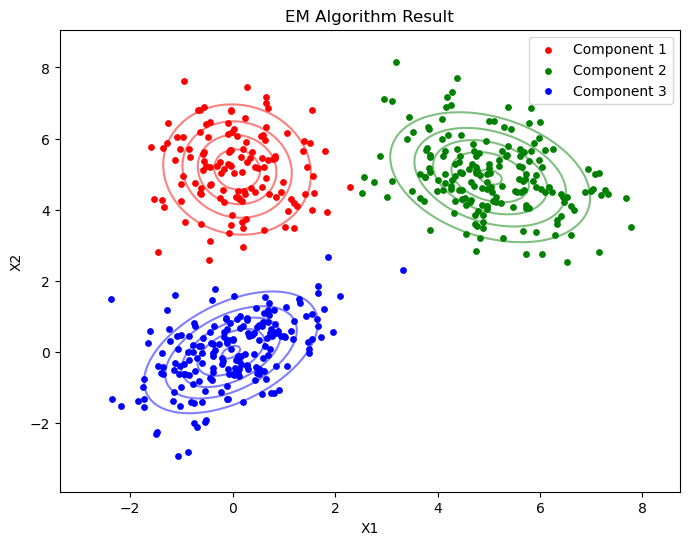

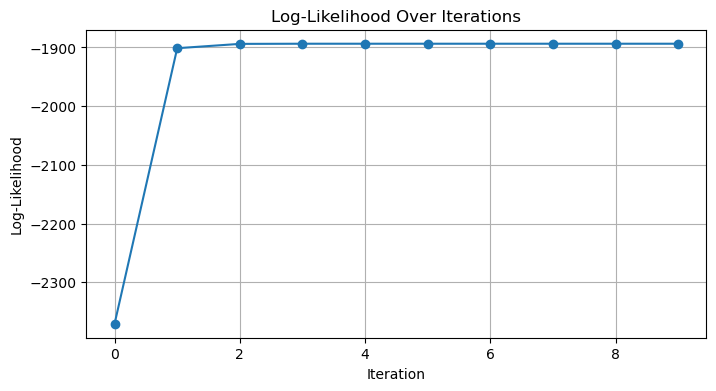

In [7]:
plt.figure(figsize=(8, 6))
colors = ["red", "green", "blue"]
for i in range(k):
    points = X[cluster_assignments == i]
    plt.scatter(
        points[:, 0], points[:, 1], s=15, color=colors[i], label=f"Component {i+1}"
    )
    rv = multivariate_normal(mean=mu[i], cov=sigma[i])
    x, y = np.mgrid[
        np.min(X[:, 0]) - 1 : np.max(X[:, 0]) + 1 : 0.1,
        np.min(X[:, 1]) - 1 : np.max(X[:, 1]) + 1 : 0.1,
    ]
    pos = np.dstack((x, y))
    plt.contour(x, y, rv.pdf(pos), levels=5, colors=colors[i], alpha=0.5)
plt.title("EM Algorithm Result")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

# 5. Plot Log-Likelihood
plt.figure(figsize=(8, 4))
plt.plot(range(len(log_likelihoods)), log_likelihoods, marker="o")
plt.title("Log-Likelihood Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid()
plt.show()
